# Dealing with imbalanced data by under or over sampling

A problem with machine learning models is that they may end up biased towards the majority class, and under-predict the minority class(es).

Here we look at two basic methods to correct for bias towards a majority class:

1) Under-sampling the majority class
2) Over-sampling the minority class

Under-sampling the majority class may be a viable method when you know that you are working with more data than the model needs for a good fit. If you are unfamiliar with model learning curves to test for this please see:

https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/11_learning_curve.ipynb

Over-sampling of the minority class may also help rebalance models. Here we use simple 'bootstrapping' (repeated sampling from our population of cases), but there are more sophisticated methods, and in our next workbook we will look at one of those - Synthetic Minority Oversampling Technique (which may also increase overall accuracy as well as achieving a better balance between correct identification of minority and majority classes).

In [1]:
# Hide warnings (to keep notebook tidy; do not usually do this)
import warnings
warnings.filterwarnings("ignore")

## Load modules

A standard Anaconda install of Python (https://www.anaconda.com/distribution/) contains all the necessary modules.

In [2]:
import numpy as np
import pandas as pd
# Import machine learning methods
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

## Load data

The section below downloads pre-processed data, and saves it to a subfolder (from where this code is run).
If data has already been downloaded that cell may be skipped.

In [3]:
download_required = True

if download_required:
    
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'
    
    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

In [4]:
data = pd.read_csv('data/processed_data.csv')
# Make all data 'float' type
data = data.astype(float)

The first column is a passenger index number. We will remove this, as this is not part of the original Titanic passenger data.

In [5]:
# Drop Passengerid (axis=1 indicates we are removing a column rather than a row)
# We drop passenger ID as it is not original data

data.drop('PassengerId', inplace=True, axis=1)

## Artificially reduce the number of survivors (to make data set more imbalanced)

In [6]:
# Shuffle original data
data = data.sample(frac=1.0) # Sampling with a fraction of 1.0 shuffles data

# Create masks for filters
mask_died = data['Survived'] == 0
mask_survived = data['Survived'] == 1

# Filter data
died = data[mask_died]
survived = data[mask_survived]

# Reduce survived by half
survived = survived.sample(frac=0.5)

# Recombine data and shuffle
data = pd.concat([died, survived])
data = data.sample(frac=1.0) 

# Show average of survived
survival_rate = data['Survived'].mean()
print ('Proportion survived:', np.round(survival_rate,3))

Proportion survived: 0.238


## Define function to standardise data

In [7]:
def standardise_data(X_train, X_test):
    
    # Initialise a new scaling object for normalising input data
    sc = StandardScaler() 

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_std=sc.transform(X_train)
    test_std=sc.transform(X_test)
    
    return train_std, test_std

## Define function to measure accuracy

The following is a function for multiple accuracy measures.

In [8]:
def calculate_accuracy(observed, predicted):
    
    """
    Calculates a range of accuracy scores from observed and predicted classes.
    
    Takes two list or NumPy arrays (observed class values, and predicted class 
    values), and returns a dictionary of results.
    
     1) observed positive rate: proportion of observed cases that are +ve
     2) Predicted positive rate: proportion of predicted cases that are +ve
     3) observed negative rate: proportion of observed cases that are -ve
     4) Predicted negative rate: proportion of predicted cases that are -ve  
     5) accuracy: proportion of predicted results that are correct    
     6) precision: proportion of predicted +ve that are correct
     7) recall: proportion of true +ve correctly identified
     8) f1: harmonic mean of precision and recall
     9) sensitivity: Same as recall
    10) specificity: Proportion of true -ve identified:        
    11) positive likelihood: increased probability of true +ve if test +ve
    12) negative likelihood: reduced probability of true +ve if test -ve
    13) false positive rate: proportion of false +ves in true -ve patients
    14) false negative rate: proportion of false -ves in true +ve patients
    15) true positive rate: Same as recall
    16) true negative rate
    17) positive predictive value: chance of true +ve if test +ve
    18) negative predictive value: chance of true -ve if test -ve
    
    """
    
    # Converts list to NumPy arrays
    if type(observed) == list:
        observed = np.array(observed)
    if type(predicted) == list:
        predicted = np.array(predicted)
    
    # Calculate accuracy scores
    observed_positives = observed == 1
    observed_negatives = observed == 0
    predicted_positives = predicted == 1
    predicted_negatives = predicted == 0
    
    true_positives = (predicted_positives == 1) & (observed_positives == 1)
    
    false_positives = (predicted_positives == 1) & (observed_positives == 0)
    
    true_negatives = (predicted_negatives == 1) & (observed_negatives == 1)
    
    accuracy = np.mean(predicted == observed)
    
    precision = (np.sum(true_positives) /
                 (np.sum(true_positives) + np.sum(false_positives)))
        
    recall = np.sum(true_positives) / np.sum(observed_positives)
    
    sensitivity = recall
    
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    specificity = np.sum(true_negatives) / np.sum(observed_negatives)
    
    positive_likelihood = sensitivity / (1 - specificity)
    
    negative_likelihood = (1 - sensitivity) / specificity
    
    false_positive_rate = 1 - specificity
    
    false_negative_rate = 1 - sensitivity
    
    true_positive_rate = sensitivity
    
    true_negative_rate = specificity
    
    positive_predictive_value = (np.sum(true_positives) / 
                                 np.sum(observed_positives))
    
    negative_predictive_value = (np.sum(true_negatives) / 
                                  np.sum(observed_negatives))
    
    # Create dictionary for results, and add results
    results = dict()
    
    results['observed_positive_rate'] = np.mean(observed_positives)
    results['observed_negative_rate'] = np.mean(observed_negatives)
    results['predicted_positive_rate'] = np.mean(predicted_positives)
    results['predicted_negative_rate'] = np.mean(predicted_negatives)
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1'] = f1
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    results['positive_likelihood'] = positive_likelihood
    results['negative_likelihood'] = negative_likelihood
    results['false_positive_rate'] = false_positive_rate
    results['false_negative_rate'] = false_negative_rate
    results['true_positive_rate'] = true_positive_rate
    results['true_negative_rate'] = true_negative_rate
    results['positive_predictive_value'] = positive_predictive_value
    results['negative_predictive_value'] = negative_predictive_value
    
    return results

## Divide into X (features) and y (labels)

We will separate out our features (the data we use to make a prediction) from our label (what we are truing to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (survive or not) `y`.

In [9]:
X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column
y = data['Survived'] # y = 'survived' column from 'data'

## Under-sampling of majority class

Here we will progressively reduce the size of the majority class examples ('died') in the training set, and look at the effect on various measures of accuracy. 

Define function to reduce size of majority class.

In [10]:
def reduce_majority_class(X, y, maj_sample_size=100):
    """
    Identify majority class (for binary classification of y) and reduce 
    size of majority class to `n` (defaults to 100). Uses bootstrap sampling,
    so will not error if requested sample size is greater than available 
    samples.
    
    Input: X and y NumPy arrays
    Output X and y NumPy arrays
    """
    
    # Get majority class
    unique_elements, counts_elements = np.unique(y, return_counts=True)
    index_max = counts_elements.argmax()
    majority_class = unique_elements[index_max]

    # Separate out classes by index
    majority_index = np.where(y == majority_class)[0]
    minority_index = np.where(y != majority_class)[0]
    
    # Sample from majority class
    restricted_sample_index = np.random.choice(
            majority_index, maj_sample_size, replace=True)
    
    # Get restricted X and y for restricted data
    X_majority_restricted = X[restricted_sample_index, :]
    y_majority_restricted = y[restricted_sample_index]
    
    # Get all of minority class
    X_minority = X[minority_index, :]
    y_minority = y[minority_index]
    
    # Combine X and y 
    X_new = np.concatenate([X_majority_restricted, X_minority])
    y_new = np.concatenate([y_majority_restricted, y_minority])
    
    # Shuffle (use random index to shuffle X and y in same order)
    count_rows = X_new.shape[0]
    random_index = np.random.permutation(count_rows)
    X_new = X_new[random_index, :]
    y_new = y_new[random_index]
    
    return X_new, y_new

Run model with varying training size of majority class

In [11]:
# Create NumPy arrays of X and y (required for k-fold)
X_np = X.values
y_np = y.values

# Create lists for overall results
results_raw_majority_count = []
results_accuracy = []
results_precision = []
results_recall = []
results_f1 = []
results_predicted_positive_rate = []

samples_sizes = list(np.arange(50, 801, 50))
for maj_sample_size in samples_sizes:

    # Set up loop for replicates for each training majority class size
    replicate_raw_majority_count = []
    replicate_accuracy = []
    replicate_precision = []
    replicate_recall = []
    replicate_f1 = []
    replicate_predicted_positive_rate = []
    
    # Set up k-fold training/test splits
    number_of_splits = 10
    skf = StratifiedKFold(n_splits = number_of_splits)
    skf.get_n_splits(X_np, y_np)
    
    # Loop through the k-fold splits
    for train_index, test_index in skf.split(X_np, y_np):
        
        # Get X and Y train/test
        X_train_full, X_test = X_np[train_index], X_np[test_index]
        y_train_full, y_test = y_np[train_index], y_np[test_index]
        
        # Record original training majority class
        count_of_training_died = (y_train_full == 0).sum()
        replicate_raw_majority_count.append(count_of_training_died)
        
        # Get restricted training set
        X_train, y_train = reduce_majority_class(
                X_train_full, y_train_full, maj_sample_size)
        
        # Get X and Y train/test
        X_train_std, X_test_std = standardise_data(X_train, X_test)
        
        # Set up and fit model
        model = LogisticRegression(solver='lbfgs')
        model.fit(X_train_std,y_train)
        
        # Predict test set labels and get accuracy scores
        y_pred_test = model.predict(X_test_std)
        accuracy_scores = calculate_accuracy(y_test, y_pred_test)
        replicate_accuracy.append(accuracy_scores['accuracy'])
        replicate_precision.append(accuracy_scores['precision'])
        replicate_recall.append(accuracy_scores['recall'])
        replicate_f1.append(accuracy_scores['f1'])
        replicate_predicted_positive_rate.append(
            accuracy_scores['predicted_positive_rate'])
                        
    # Add mean results to overall results
    results_raw_majority_count.append(np.mean(replicate_raw_majority_count))
    results_accuracy.append(np.mean(replicate_accuracy))
    results_precision.append(np.mean(replicate_precision))
    results_recall.append(np.mean(replicate_recall))
    results_f1.append(np.mean(replicate_f1))
    results_predicted_positive_rate.append(
        np.mean(replicate_predicted_positive_rate))

# Transfer results to dataframe
results = pd.DataFrame(samples_sizes, columns=['Sample_size'])
results['accuracy'] = results_accuracy
results['precision'] = results_precision
results['recall'] = results_recall
results['f1'] = results_f1
results['predicted_positive_rate'] = results_predicted_positive_rate

Plot results

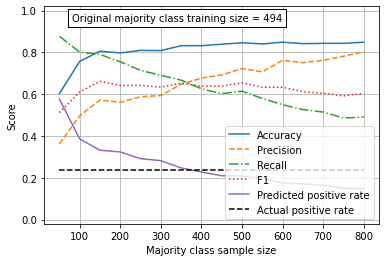

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

chart_x = results['Sample_size']

plt.plot(chart_x, results['accuracy'],
         linestyle = '-',
         label = 'Accuracy')

plt.plot(chart_x, results['precision'],
         linestyle = '--',
         label = 'Precision')

plt.plot(chart_x, results['recall'],
         linestyle = '-.',
         label = 'Recall')

plt.plot(chart_x, results['f1'],
         linestyle = ':',
         label = 'F1')

plt.plot(chart_x, results['predicted_positive_rate'],
         linestyle = '-',
         label = 'Predicted positive rate')

actual_positive_rate = np.repeat(y.mean(), len(chart_x))

plt.plot(chart_x, actual_positive_rate,
         linestyle = '--',
         color='k',
         label = 'Actual positive rate')

# Add text showing original majority class training size
original_majority_training_sample = int(np.mean(results_raw_majority_count))
text = 'Original majority class training size = ' + str(
    original_majority_training_sample)


plt.text(80, 0.95,text, bbox=dict(facecolor='white', alpha=1.0))

plt.xlabel('Majority class sample size')
plt.ylabel('Score')
plt.ylim(-0.02, 1.02)
plt.legend(loc='lower right')
plt.grid(True)

plt.show()

### Observations

* Without under-sampling of the majority class, the minority class ('survived') is under-predicted.
* By under-sampling the majority class in the training data set the model becomes more balanced, and correctly predicts the proportion of passengers who survive.
* Balancing the model by under-sampling in this example caused a small reduction in accuracy of the model.

## Over-sampling of minority class

Here we will progressively increase the size of the minority class examples ('survived') in the training set, and look at the effect on various measures of accuracy. Over-sampling is achieved by repeatedly re-sampling from the original data.

Define function to over-sample minority class.

In [13]:
def increase_majority(X, y, maj_sample_size=100):
    """
    Identify majority class (for binary classification of y) and reduce 
    size of majority class to `n` (defaults to 100). Uses bootstrap sampling,
    so will not error if requested sample size is greater than available 
    samples.
    
    Input: X and y NumPy arrays
    Output X and y NumPy arrays
    """
    
    # Get minority class
    unique_elements, counts_elements = np.unique(y, return_counts=True)
    index_max = counts_elements.argmin()
    minority_class = unique_elements[index_max]

    # Separate out classes by index
    minority_index = np.where(y == minority_class)[0]
    majority_index = np.where(y != minority_class)[0]
    
    # Sample from majority class
    enhanced_sample_index = np.random.choice(
            minority_index, maj_sample_size, replace=True)
    
    # Get restricted X and y for restricted data
    X_minority_enhanced = X[enhanced_sample_index, :]
    y_minority_enhanced = y[enhanced_sample_index]
    
    # Get all of majority class
    X_majority = X[majority_index, :]
    y_majority = y[majority_index]
    
    # Combine X and y 
    X_new = np.concatenate([X_minority_enhanced, X_majority])
    y_new = np.concatenate([y_minority_enhanced, y_majority])
    
    # Shuffle (use random index to shuffle X and y in same order)
    count_rows = X_new.shape[0]
    random_index = np.random.permutation(count_rows)
    X_new = X_new[random_index, :]
    y_new = y_new[random_index]
    
    return X_new, y_new

Run model with varying training size of minority class.

In [14]:
# Create NumPy arrays of X and y (required for k-fold)
X_np = X.values
y_np = y.values

# Create lists for overall results
results_raw_minority_count = []
results_accuracy = []
results_precision = []
results_recall = []
results_f1 = []
results_predicted_positive_rate = []

samples_sizes = list(np.arange(50, 801, 50))
for maj_sample_size in samples_sizes:

    # Set up loop for replicates for each training majority class size
    replicate_raw_minority_count = []
    replicate_accuracy = []
    replicate_precision = []
    replicate_recall = []
    replicate_f1 = []
    replicate_predicted_positive_rate = []
    
    # Set up k-fold training/test splits
    number_of_splits = 10
    skf = StratifiedKFold(n_splits = number_of_splits)
    skf.get_n_splits(X_np, y_np)
    
    # Loop through the k-fold splits
    for train_index, test_index in skf.split(X_np, y_np):
        
        # Get X and Y train/test
        X_train_full, X_test = X_np[train_index], X_np[test_index]
        y_train_full, y_test = y_np[train_index], y_np[test_index]
        
        # Record original training majority class
        count_of_training_survived = (y_train_full == 1).sum()
        replicate_raw_minority_count.append(count_of_training_survived)
        
        # Get enhances training set
        X_train, y_train = increase_majority(
                X_train_full, y_train_full, maj_sample_size)
        
        # Get X and Y train/test
        X_train_std, X_test_std = standardise_data(X_train, X_test)
        
        # Set up and fit model
        model = LogisticRegression(solver='lbfgs')
        model.fit(X_train_std,y_train)
        
        # Predict test set labels and get accuracy scores
        y_pred_test = model.predict(X_test_std)
        accuracy_scores = calculate_accuracy(y_test, y_pred_test)
        replicate_accuracy.append(accuracy_scores['accuracy'])
        replicate_precision.append(accuracy_scores['precision'])
        replicate_recall.append(accuracy_scores['recall'])
        replicate_f1.append(accuracy_scores['f1'])
        replicate_predicted_positive_rate.append(
            accuracy_scores['predicted_positive_rate'])
                        
    # Add mean results to overall results
    results_raw_minority_count.append(np.mean(replicate_raw_minority_count))
    results_accuracy.append(np.mean(replicate_accuracy))
    results_precision.append(np.mean(replicate_precision))
    results_recall.append(np.mean(replicate_recall))
    results_f1.append(np.mean(replicate_f1))
    results_predicted_positive_rate.append(
        np.mean(replicate_predicted_positive_rate))

# Transfer results to dataframe
results = pd.DataFrame(samples_sizes, columns=['Sample_size'])
results['accuracy'] = results_accuracy
results['precision'] = results_precision
results['recall'] = results_recall
results['f1'] = results_f1
results['predicted_positive_rate'] = results_predicted_positive_rate

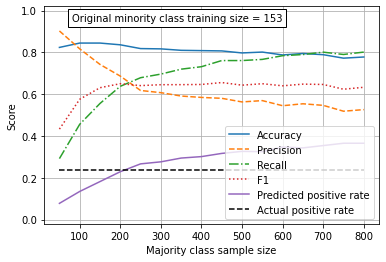

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

chart_x = results['Sample_size']

plt.plot(chart_x, results['accuracy'],
         linestyle = '-',
         label = 'Accuracy')

plt.plot(chart_x, results['precision'],
         linestyle = '--',
         label = 'Precision')

plt.plot(chart_x, results['recall'],
         linestyle = '-.',
         label = 'Recall')

plt.plot(chart_x, results['f1'],
         linestyle = ':',
         label = 'F1')

plt.plot(chart_x, results['predicted_positive_rate'],
         linestyle = '-',
         label = 'Predicted positive rate')

actual_positive_rate = np.repeat(y.mean(), len(chart_x))

plt.plot(chart_x, actual_positive_rate,
         linestyle = '--',
         color='k',
         label = 'Actual positive rate')

# Add text showing original majority class training size
original_minority_training_sample = int(np.mean(results_raw_minority_count))
text = 'Original minority class training size = ' + str(
    original_minority_training_sample)


plt.text(80, 0.95,text, bbox=dict(facecolor='white', alpha=1.0))

plt.xlabel('Majority class sample size')
plt.ylabel('Score')
plt.ylim(-0.02, 1.02)
plt.legend(loc='lower right')
plt.grid(True)

plt.show()

### Observations

* Without over-sampling of the minority class, the minority class ('survived') is under-predicted.
* By over-sampling the majority class in the training data set the model becomes more balanced, and correctly predicts the proportion of passengers who survive.
* Balancing the model by over-sampling in this example had little effect of accuracy.

## Overall observations

Both under-sampling of the majority class, or over-sampling of the minority class, can balance the performance of the model across different classes. Balancing the model leads to better prediction of the proportion in each class (e.g. 'survived' or 'died'), but this may come at a small loss in overall accuracy.